In [292]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.utils.data as data
import torch.nn.functional as F

import nltk.corpus
nltk.download('stopwords')
from nltk.corpus import stopwords

import nltk 
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
!nvidia-smi

Sat Sep 25 13:23:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Data Preparation

In [7]:
cd '/content/drive/MyDrive/Colab Notebooks/SoftComputing Assignment 3'

/content/drive/MyDrive/Colab Notebooks/SoftComputing Assignment 3


In [8]:
df=pd.read_csv('Dataset 2.csv',encoding = "ISO-8859-1")
df.head()

,text,polarity
0,just had a real good moment. i missssssssss hi...,0
1,is reading manga http://plurk.com/p/mzp1e,0
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,@lapcat Need to send 'em to my accountant tomo...,0
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0


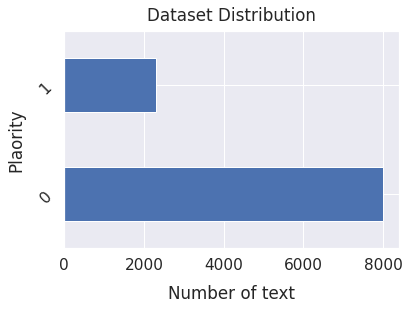

In [9]:
sns.set(font_scale=1.4)
df['polarity'].value_counts().plot(kind='barh', figsize=(6,4))
plt.xlabel('Number of text', labelpad=12)
plt.ylabel('Plaority', labelpad=12)
plt.yticks(rotation = 45)
plt.title("Dataset Distribution", y=1.02);

### Data Cleaning

In [194]:
def cleaning(text):
  text=text.lower()
  text=re.sub(r"(@[A-Za-z0-9]+)|(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", " ", str(text))

  stop = stopwords.words('english')
  text = " ".join([word for word in text.split() if word not in (stop)])

  return text

df['cleaned_text']=df['text'].apply(cleaning)

indices=[2500, 3000, 5000, 7800, 9700]
for i in indices:
    print('Original Data--> ',df['text'][i])
    print('Cleaned Data--> ',df['cleaned_text'][i])
    print('Polarity--> ',df['polarity'][i])
    print('\n')

Original Data-->  @highheelznkickz its ok; the 1st step is deniallll  LOL
Cleaned Data-->  ok 1st step deniallll lol
Polarity-->  0


Original Data-->  @Teamcyrus I love you! I dont think i have ever met anyone as kind as you! And well done for getting 1000 followers! 
Cleaned Data-->  love dont think ever met anyone kind well done getting 1000 followers
Polarity-->  0


Original Data-->  @Clareies  whip out out the after sun and moisturiser!
Cleaned Data-->  whip sun moisturiser
Polarity-->  0


Original Data-->  http://twitpic.com/7j5nc - breakfast after a long night 
Cleaned Data-->  breakfast long night
Polarity-->  0


Original Data-->  distant myself for it then dwell on my misery and trigger my depression not that I have being happy or feeling good about myself these past days . So yeah I wanna take a break from it all and just spend time doing stuff I like/love
Cleaned Data-->  distant dwell misery trigger depression happy feeling good past days yeah wanna take break spend time

### Removing Empty Data

In [195]:
df['Length']=df['cleaned_text'].apply(lambda x: len(x.split()))
print('Total Text: ',len(df))
dataset=df.loc[df.Length>0]
dataset=dataset.reset_index(drop=True)
print('Removed Texts:  ',len(df)-len(dataset))
print('Total Text:  ',len(dataset))

Total Text:  10314
Removed Texts:   34
Total Text:   10280


### Dataset Analysis

In [196]:
class_labels=[k for k,v in dataset['polarity'].value_counts().to_dict().items()]
    
documents=[]
words=[]
u_words=[]
total_words=[word.strip() for t in list(df['cleaned_text']) for word in t.strip().split()]

def data_summary(dataset):
    print('Total Words:  {}\n'.format(len(total_words)))
    for label in class_labels:
        words_list = [word for t in dataset[dataset.polarity==label].cleaned_text for word in t.strip().split()]
        
        counts=dict()
        for w in words_list:
            counts[w]=counts.get(w,0)+1
        
        ordered=sorted(counts.items(), key=lambda x:x[1], reverse=True)
        
        documents.append(len(list(dataset[dataset.polarity==label].cleaned_text)))
        u_words.append(len(np.unique(words_list)))
        words.append(len(words_list))
        
        print('Category:-->{}'.format(label))
        print('Number of documents:-->{}'.format(len(list(dataset[dataset.polarity==label].cleaned_text))))
        print('Number of Words:-->{}'.format(len(words_list)))
        print('Number of Unique Words-->{}'.format(len(np.unique(words_list))))
        
        print('Most Unique Words: \n')
        for k,v in ordered[:10]:
            print('{}--->{}'.format(k,v))
        print('\n')
    
    print('Total Unique Words:  {}'.format(len(np.unique(total_words))))

In [197]:
data_summary(dataset)

Total Words:  86021

Category:-->0
Number of documents:-->7966
Number of Words:-->56177
Number of Unique Words-->11712
Most Unique Words: 

good--->616
day--->491
love--->478
quot--->427
lol--->399
get--->369
like--->358
thanks--->347
time--->323
today--->321


Category:-->1
Number of documents:-->2314
Number of Words:-->29844
Number of Unique Words-->7236
Most Unique Words: 

depression--->2367
anxiety--->392
emoji--->343
twitter--->299
com--->281
pic--->280
face--->205
like--->199
people--->163
know--->129


Total Unique Words:  15748


### Summary Visualization

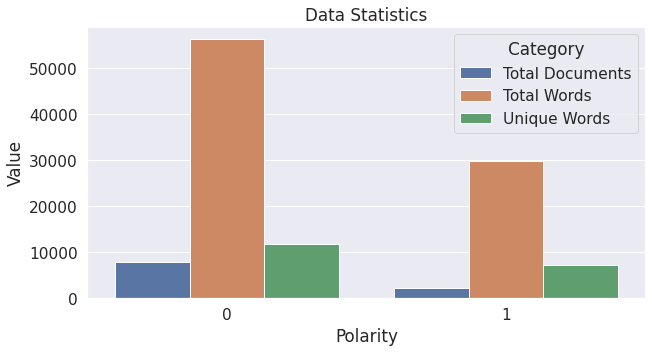

In [198]:
data_matrix=pd.DataFrame({'Total Documents': documents,
                         'Total Words': words,
                         'Unique Words': u_words,
                         'Polarity': class_labels})

d=pd.melt(data_matrix,id_vars='Polarity', var_name='Category', value_name='Value')
plt.figure(figsize=(10,5))
ax=plt.subplot()

sns.barplot(data=d, x='Polarity', y='Value', hue='Category')
ax.set_xlabel('Polarity')
ax.set_title('Data Statistics');

### Headline Length Distribution

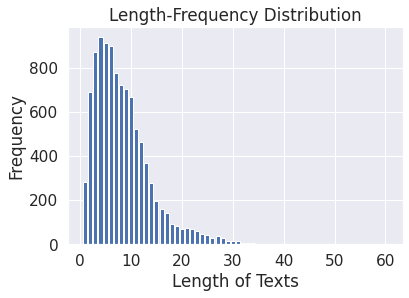

Maximum Length of a text: 60
Minimum Length of a text: 1
Average Length of a text: 8.0


In [199]:
text_lengths=list(dataset['cleaned_text'].apply(lambda x:len(x.split())))
frequencies=dict()
for l in text_lengths:
    frequencies[l]=frequencies.get(l,0)+1

plt.bar(x=frequencies.keys(), height=frequencies.values());
plt.xlabel('Length of Texts')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
plt.show()
print(f"Maximum Length of a text: {max(text_lengths)}")
print(f"Minimum Length of a text: {min(text_lengths)}")
print(f"Average Length of a text: {round(np.mean(text_lengths),0)}")

### Label Encoding and Dataset Splitting

In [200]:
def label_encoding(category):
    le=LabelEncoder()
    le.fit(category)
    encoded_labels=np.array(le.transform(category))
    
    sample_ids=[1000,9120,23]
    for i in sample_ids:
        print('{}--->{}'.format(category[i], encoded_labels[i]))
    return encoded_labels

In [201]:
labels=label_encoding(dataset.polarity)

0--->0
1--->1
0--->0


In [202]:
def dataset_splitting(texts, category):
    X,X_test,y,y_test=train_test_split(texts, category, train_size=0.8, test_size=0.2, random_state=0)
    X_train, X_valid, y_train, y_valid=train_test_split(X,y,train_size=0.8, test_size=0.2, random_state=0)
    
    print('Dataset Distribution:\n')
    print('\tSet\t\tData')
    print("\t========\t======")
    print('\tTotal:\t\t{}'.format(len(texts)))
    print('\tTrain:\t\t{}'.format(len(X_train)))
    print('\tTest:\t\t{}'.format(len(X_test)))
    print('\tValid:\t\t{}'.format(len(X_valid)))
    
    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [203]:
X_train,X_valid,X_test,y_train,y_valid,y_test=dataset_splitting(dataset.cleaned_text, labels)

Dataset Distribution:

	Set		Data
	========	======
	Total:		10280
	Train:		6579
	Test:		2056
	Valid:		1645


### Tokenization and Word Embedding

In [204]:
tokens = nltk.word_tokenize(X_train.iloc[5000])
tokens

['rain',
 'dark',
 'sky',
 'muddy',
 'streaks',
 'reflect',
 'depression',
 'vibrant',
 'colors',
 'reflect',
 'state',
 'happiness',
 'state',
 'mind',
 'clouds',
 'wanting',
 'see',
 'colors',
 'feel',
 'pain',
 'key',
 'emoji',
 'key',
 'wan',
 'na',
 'fly',
 'high',
 'sky',
 'emoji',
 'sparkles']

In [384]:
def load_glove_model(glove_file):
  f = open(glove_file, 'r', encoding='utf-8')
  glove_model = {}
  
  for line in f:
    split_line = line.split()
    word = split_line[0]
    embedding = np.array([float(val) for val in split_line[1:]])
    glove_model[word] = embedding
  return glove_model

In [385]:
glove_100d=load_glove_model('glove.6B.100d.txt')

In [386]:
glove_100d['rafi']

array([-0.3876   , -0.35314  , -0.18072  , -0.50791  ,  0.27295  ,
       -0.18192  , -0.46117  , -0.046278 ,  0.16253  ,  0.4783   ,
        0.10224  , -0.55239  ,  0.31046  ,  0.0247   ,  0.98956  ,
       -0.47668  ,  0.1632   ,  0.012663 ,  0.025041 ,  0.14433  ,
       -0.48525  ,  0.13617  ,  1.2415   , -0.21724  ,  0.24304  ,
       -0.69695  , -0.014742 , -0.29547  ,  0.8213   ,  0.25436  ,
        0.02713  ,  0.096583 ,  0.074758 ,  0.78461  , -0.56231  ,
       -0.20428  ,  0.43257  ,  0.6758   , -0.34205  , -0.19555  ,
        0.4516   ,  0.66367  ,  0.13821  ,  1.2422   , -0.29689  ,
       -0.0020224, -0.29231  ,  0.34036  , -0.34489  ,  0.47442  ,
        0.23564  , -0.17236  ,  0.38493  ,  0.38334  , -0.23221  ,
        0.82314  ,  0.099658 ,  0.81496  , -0.6997   ,  0.99081  ,
        0.25049  ,  0.22499  ,  0.21795  , -0.0091073,  0.22952  ,
        0.12652  ,  0.66787  ,  0.52669  ,  0.47243  ,  0.27819  ,
        0.2398   , -0.1932   ,  0.23892  , -1.1703   , -0.0278

In [387]:
len(glove_100d)

400000

In [388]:
def embed_text(text):
    lst=[]
    lst_pad=[[0]*100]*60

    words=nltk.word_tokenize(text) 
      
    n=len(words)
  
    for t in words:
        try:
            embedded=list(glove_100d[t])
            lst.append(embedded)
        except:
            lst.append(list(np.random.rand(100)))
    
    lst_pad[:n]=lst
    embedding=np.array(lst_pad)

    embedding=torch.from_numpy(embedding)
    embedding=embedding.float()

    return embedding

In [389]:
embed_text(X_train.iloc[6300])

tensor([[ 0.2600,  0.1120,  0.5006,  ..., -0.1560,  0.3137,  0.0413],
        [ 0.2496,  0.2125,  0.5448,  ..., -0.7064,  0.5269,  1.0409],
        [-0.1287,  0.3006,  0.8346,  ..., -0.2997,  0.4868,  0.5650],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [390]:
le=LabelEncoder()
le.fit(dataset['polarity'])
le.classes_
le.inverse_transform([y_train[6300]])

array([0])

### Dataset Creation

In [391]:
class TextDataset(data.Dataset):
    def __init__(self, text, label):
        super(TextDataset, self).__init__()
        
        self.texts=list(text)
        self.labels=label
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        h=self.texts[idx]
        a=self.labels[idx]
        
        #print('Text:  ',h)
        embedding=embed_text(h)
        #print('Answer: ',le.inverse_transform([a]))
        
        return embedding,a

In [392]:
train_set=TextDataset(X_train,y_train)
train_set.__getitem__(6300)

(tensor([[ 0.2600,  0.1120,  0.5006,  ..., -0.1560,  0.3137,  0.0413],
         [ 0.2496,  0.2125,  0.5448,  ..., -0.7064,  0.5269,  1.0409],
         [-0.1287,  0.3006,  0.8346,  ..., -0.2997,  0.4868,  0.5650],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]), 0)

In [393]:
train_set.texts

['going bed night guys',
 'hey wondering whereabouts uganda guys went im going july wondering im going place xx',
 'okay take tomorrow going use one already needs new roller love typewriters',
 'afraid use 4 letter words',
 'hi xaviermedia found way get thousands twitter followers check',
 'looking forward evry song love love xoxox sophie please please reply',
 'irish german spunk mix',
 'ok ok depression mentalhealth lovelife workhard smile happy beautifullife lovelife goals keepontrying summeriscoming',
 'pleasure great site use lot iphone ringtones',
 'lmao try stop visiting everyone tomorrow',
 'sun shining going studio go sea problem',
 'playing wsop ladies event tomorrow let ya know goes',
 'quote day quot walk softly carry big magnifying glass quot richard lacayo',
 'got bb bac function',
 'depression hits anxiety',
 'christian read persecution alot recieve alotsince march',
 'mmmmmm thats pretty much route im going reckons',
 'night babies got vh1 thing check pics',
 'jenn want

In [394]:
valid_set=TextDataset(X_valid,y_valid)
valid_set.__getitem__(1)

(tensor([[ 0.3777,  0.4261,  1.1580,  ..., -0.1098, -0.3544,  0.3808],
         [-0.1878,  0.2195,  0.9650,  ..., -0.0907, -0.5417, -0.0729],
         [ 0.2269, -0.3614,  0.1946,  ...,  0.3693, -0.4074, -0.0385],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]), 0)

In [395]:
test_set=TextDataset(X_test,y_test)
test_set.__getitem__(1)

(tensor([[ 0.0227,  0.2415,  0.1644,  ..., -0.7390,  0.4408, -0.0128],
         [ 0.0036, -0.4664, -0.0620,  ...,  0.0418, -0.1353, -0.0095],
         [ 0.0357,  0.3335,  0.2989,  ...,  0.6642,  0.0112,  0.0728],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]), 0)

In [396]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [482]:
class BiRNN(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_size, num_layers, bidirectional=True):
        super(BiRNN, self).__init__()
        
        self.embedding_dim=embedding_dim
        self.hidden_dim=hidden_dim
        self.num_layers=num_layers
        self.output_size=output_size
        
        self.brnn=nn.RNN(embedding_dim, hidden_dim, num_layers, bidirectional=bidirectional, batch_first=True)
        
        self.fc1=nn.Linear(hidden_dim*2, 64)
        self.fc2=nn.Linear(64,64)
        self.final_layer=nn.Linear(64,output_size)
        
        self.dropout=nn.Dropout(0.5)
        self.relu=nn.ReLU()
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, embedding):
        h0 = torch.zeros(self.num_layers*2, embedding.size(0), self.hidden_dim).to(device)

        out_,hidden=self.brnn(embedding,h0)

        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)

        out=self.relu(self.fc1(hidden))
        out=self.batchnorm1(out)
        out=self.relu(self.fc2(out))
        out=self.batchnorm2(out)
        out=self.dropout(out)
        out=self.final_layer(out)
        
        return out

In [483]:
model=BiRNN(embedding_dim=100,hidden_dim=64,output_size=1,num_layers=3).to(device)
model

BiRNN(
  (brnn): RNN(100, 64, num_layers=3, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (final_layer): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [484]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_params

83649

### Hyperparameters

In [485]:
learning_rate=0.001
batch=256
epoch=7

optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion=nn.BCEWithLogitsLoss()

### Model Training

In [486]:
train_loader=DataLoader(dataset=train_set, batch_size=batch, shuffle=True)
valid_loader=DataLoader(dataset=valid_set, batch_size=batch, shuffle=True)
test_loader=DataLoader(dataset=test_set, batch_size=batch)

In [487]:
train_loss=[]
train_acc=[]
valid_loss=[]
valid_acc=[]

print('<-----------------Start Training------------------->')
for ep in range(epoch):
    model.train()
    num_updates, accuracy, loss_=0.0,0.0,0.0
    v_acc, v_loss, v_count=0.0,0.0,0.0
    t_acc=[]
    p_acc=[]

    for i,n in train_loader:
        embedding=i.to(device)
        label=n.to(device)

        optimizer.zero_grad()
        output=model(embedding)
        y_pred=torch.round(torch.sigmoid(output)).squeeze()

        loss=criterion(output,label.unsqueeze(1).float())
        loss.backward()
        optimizer.step()
        
        accuracy+=torch.sum(y_pred==label)
        loss_+=loss.item()

        t_acc.extend(label)
        p_acc.extend(y_pred)
        
        num_updates+=1
        
    train_loss.append(loss_/(num_updates))

    for j in range(len(t_acc)):
      t_acc[j]=t_acc[j].item()
      p_acc[j]=p_acc[j].item()

    train_acc.append(accuracy_score(t_acc,p_acc))
    
    print('Epoch {}--> Loss: {}   Accuracy: {}'.format(ep,(loss_/(num_updates)),(accuracy_score(t_acc,p_acc))))
    
    t_acc=[]
    p_acc=[]
    with torch.no_grad():
        model.eval()
        for embedd, ans in valid_loader:
            embedd=embedd.to(device)
            ans=ans.to(device)
            op=model(embedd)
            ypred=torch.round(torch.sigmoid(op)).squeeze()

            l=criterion(op,ans.unsqueeze(1).float())

            v_acc+=torch.sum(ypred==ans)
            v_loss+=l.item()

            t_acc.extend(ans)
            p_acc.extend(ypred)

            v_count+=1
    
    valid_loss.append(v_loss/(v_count))

    for j in range(len(t_acc)):
      t_acc[j]=t_acc[j].item()
      p_acc[j]=p_acc[j].item()

    valid_acc.append(accuracy_score(t_acc,p_acc))
    
    print('\t\tValidation Loss:  {}  Validation Accuracy:  {}'.format((v_loss/(v_count)),(accuracy_score(t_acc,p_acc))))
        
print('<-----------------Finished Training------------------->')

<-----------------Start Training------------------->
Epoch 0--> Loss: 0.4536888702557637   Accuracy: 0.7923696610427117
		Validation Loss:  0.18840070281709945  Validation Accuracy:  0.9610942249240122
Epoch 1--> Loss: 0.10885860255131355   Accuracy: 0.986016111871105
		Validation Loss:  0.06047574324267251  Validation Accuracy:  0.9860182370820668
Epoch 2--> Loss: 0.08037521589833957   Accuracy: 0.9844961240310077
		Validation Loss:  0.16344974083559854  Validation Accuracy:  0.9556231003039514
Epoch 3--> Loss: 0.04590382942786583   Accuracy: 0.9920960632314941
		Validation Loss:  0.027404952927359512  Validation Accuracy:  0.9963525835866262
Epoch 4--> Loss: 0.03254300463371552   Accuracy: 0.9952880376956984
		Validation Loss:  0.028785934671759605  Validation Accuracy:  0.9945288753799392
Epoch 5--> Loss: 0.028021318193238515   Accuracy: 0.9954400364797081
		Validation Loss:  0.03750524590057986  Validation Accuracy:  0.9957446808510638
Epoch 6--> Loss: 0.029791689943522215   Accura

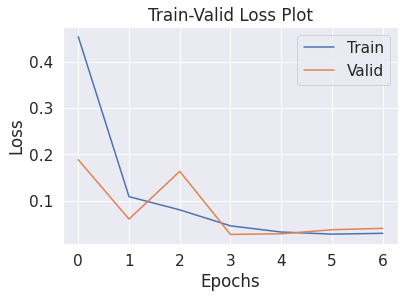

In [488]:
import matplotlib.pyplot as plt
epochs_=[]
for i in range(7):
    epochs_.append(i)
plt.plot(epochs_,train_loss,label='Train')
plt.plot(epochs_,valid_loss,label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train-Valid Loss Plot')
plt.legend()
plt.show()

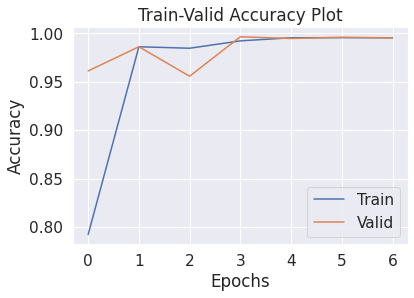

In [490]:
import matplotlib.pyplot as plt
epochs_=[]
for i in range(7):
    epochs_.append(i)
plt.plot(epochs_,train_acc,label='Train')
plt.plot(epochs_,valid_acc,label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train-Valid Accuracy Plot')
plt.legend()
plt.show()

### Model Testing

In [491]:
test_labels=[]
predicted_labels=[]

with torch.no_grad():
    test_acc, test_loss, test_count=0.0,0.0,0.0
    model.eval()
    for embedd, ans in test_loader:
        embedd=embedd.to(device)
        ans=ans.to(device)
        op=model(embedd)
        
        ypred=torch.round(torch.sigmoid(op)).squeeze()

        test_labels.extend(ans)
        predicted_labels.extend(ypred)

        l=criterion(op,ans.unsqueeze(1).float())

        test_acc+=torch.sum(ypred==ans)
        test_loss+=l.item()

        test_count+=1

    test_loss_score=test_loss/(test_count)

### Result Analysis

In [492]:
test_seq_labels=[]
for k in range(len(test_labels)):
    test_seq_labels.append(test_labels[k].to(device).item())

pred_seq_labels=[]
for k in range(len(predicted_labels)):
    pred_seq_labels.append(predicted_labels[k].to(device).item())

print('\033[1m Test Loss:  {0:0.4f}  Test Accuracy:  {1:0.4f} \033[0;0m'.format((test_loss_score),(accuracy_score(test_seq_labels,pred_seq_labels))))

 Test Loss:  0.0252  Test Accuracy:  0.9956 


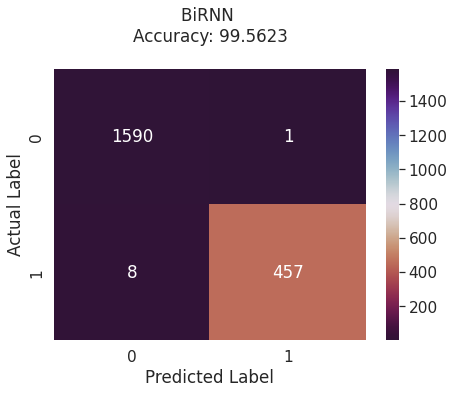

In [493]:
cm=confusion_matrix(test_seq_labels, pred_seq_labels)
cm_df=pd.DataFrame(cm, index=['0','1'],
                  columns=['0','1'])

plt.figure(figsize=(7,5))
sns.heatmap(cm_df, annot=True,fmt='g',cmap="twilight_shifted_r")
plt.title('BiRNN \nAccuracy: {0:.4f}\n'.format(accuracy_score(test_seq_labels,pred_seq_labels)*100))
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

In [494]:
report = pd.DataFrame(classification_report(y_true = test_seq_labels, y_pred = pred_seq_labels, output_dict=True)).transpose()
report = report.rename(index={'0': '0','1':'1'})
report[['precision','recall','f1-score']]=report[['precision','recall','f1-score']].apply(lambda x: round(x*100,2))
report

,precision,recall,f1-score,support
0,99.50,99.94,99.72,1591.000000
1,99.78,98.28,99.02,465.000000
accuracy,99.56,99.56,99.56,0.995623
macro avg,99.64,99.11,99.37,2056.000000
weighted avg,99.56,99.56,99.56,2056.000000
